#Finding home

As an Asian parent looking for a place to live, I'm looking for a place with the best space to price ratio, while having the most number of Chinese/Asian restaurants, and located near good schools for my children. Unfortunately, most single sets of public data only have a single aspect of housing price data, restaurant info, or school grade. I would like to find the best neighborhood/zip code with a combination of these values given a budget.

In [1]:
import numpy as np
import pandas as pd
import requests
import os.path
import re
import time
import json

In [91]:
# set a budget for buying house
budget_amount = 270000
built_year = 1950
grade = 8

I first decided to get the property tax data from the City of New York
https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-data-Tax-Class/qpsp-bm9z

In [3]:
# import data from NYC Property Valuation and Assessment data 
# https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-data-Tax-Class/qpsp-bm9z

data = pd.read_csv('TC1.txt')

/home/yangliu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,4,53,87,90,93,97,100,106,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I then filtered the total value (CUR_FV_L column) by '> 200,000 and < 270,000' to fit the desired budget of $270,000. 
Filter the building by years built after 1950

In [92]:
# Filter by budget, set as 20% above and below budget

budget = data.loc[data['CUR_FV_T'] < 1.2 * budget_amount]
budget = budget.loc[budget['CUR_FV_T'] > 0.8 * budget_amount]

# Find places built after 1950
after_built_year = budget.loc[budget['YRB'] >= built_year]
valid_address = after_built_year[pd.notnull(after_built_year['HNUM_LO'])]
price_by_zip = valid_address.groupby(by=['ZIP'])['CUR_FV_T'].mean()

Cross check with NYC restaurant health inspection data to find the zip codes with the most number of "Grade A" restaurants. From: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59

In [5]:
# imported the NYC restaurant inspection data to look at nearby restaurants
# https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59

food = pd.read_csv('NYC_Restaurant_inspection.csv')

/home/yangliu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# find unique places by last inspection
unique_food = food
unique_food.drop_duplicates(subset = 'DBA', inplace = True)

In [7]:
# find clean Chinese places
clean_food=unique_food.loc[unique_food['GRADE'] == 'A']
chinese_food = clean_food.loc[unique_food['CUISINE DESCRIPTION'] == 'Chinese']

In [8]:
# group places by zip code
food_by_zip=chinese_food.groupby(by=['ZIPCODE'])['GRADE'].count()

In [9]:
#combine food and mean price into one dataframe
food_and_price = pd.concat([food_by_zip, price_by_zip], axis=1)

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

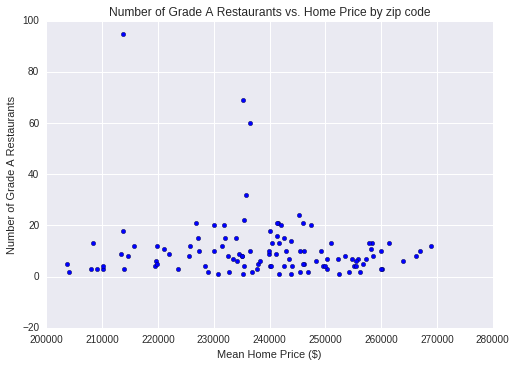

In [12]:
# make a plot for number of restaurants in zip code vs. home price
sns.plt.scatter(food_and_price['CUR_FV_T'], food_and_price['GRADE'])
sns.plt.title('Number of Grade A Restaurants vs. Home Price by zip code')
sns.plt.xlabel('Mean Home Price ($)')
sns.plt.ylabel('Number of Grade A Restaurants')

Three zip codes stand out with the most number of Chinese Restaurants. 

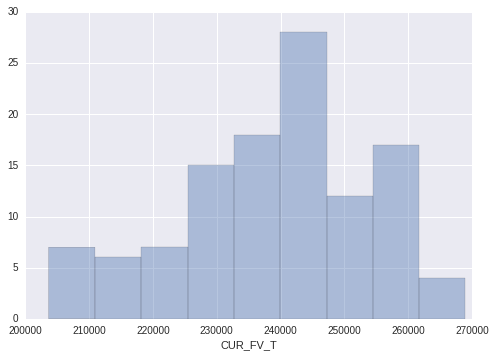

In [13]:
#look at the distribution of prices by zipcode
nonzero_price = food_and_price[pd.notnull(food_and_price['CUR_FV_T'])]
sns.distplot(nonzero_price['CUR_FV_T'], kde=False)

In [14]:
# take out invalid prices
short_list= food_and_price[pd.notnull(food_and_price['CUR_FV_T'])]
short_list= short_list.sort('GRADE', ascending=False)
short_list.head(3)

# the top 3 areas include 11354, 10002 and 11355
# can expand to other zip codes if no valid results are found

/home/yangliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,GRADE,CUR_FV_T
11354.0,95.0,213652.00
10002.0,69.0,235194.75
11355.0,60.0,236463.00


In [15]:
home_with_food = valid_address.loc[valid_address['ZIP'].isin([11354,10002,11355])]

Use Zillows  API to find these places and scraped each zillow page to see if the property is: 1) on the market, and 2) near a good school.

In [27]:
# zillow API function, have 1000 request per day limit
# only use after getting small number of interested properties

from pyzillow.pyzillow import ZillowWrapper, GetDeepSearchResults, GetUpdatedPropertyDetails
# pyzillow 
# https://github.com/hanneshapke/pyzillow

YOUR_ZILLOW_API_KEY = 'X1-ZWz1fcz57zvjt7_6jziz'

zillow_link = []
for i in range(len(home_with_food)):
    # sometimes zillow API wrapper dones't accept address/zipcode, even though they are strings
    try:
        # convert process street numbers for zillow API wrapper
        street_num = home_with_food.iloc[i]['HNUM_LO']

        if (street_num.isdigit() is False):
            street_num = ''.join(c for c in street_num if c.isdigit())
        number = int(street_num)

        # assing address and zipcode
        address = str(number) + ' ' + str(home_with_food.iloc[i]['STR_NAME'])
        zipcode = str(int(home_with_food.iloc[i]['ZIP']))

        #use zillow API wrapper to get website link for this property
        zillow_data = ZillowWrapper(YOUR_ZILLOW_API_KEY)
        deep_search_response = zillow_data.get_deep_search_results(address, zipcode)
        result = GetDeepSearchResults(deep_search_response)

        zillow_link.append(result.home_detail_link)
    except:
        print "error on line", i
        pass

In [37]:
links = pd.DataFrame(zillow_link)
links.columns=['Zillow Links']

In [48]:
zillow_link

['http://www.zillow.com/homedetails/305-Cherry-St-APT-F1-New-York-NY-10002/31495191_zpid/',
 'http://www.zillow.com/homedetails/305-Cherry-St-APT-F1-New-York-NY-10002/31495191_zpid/',
 'http://www.zillow.com/homedetails/305-Cherry-St-APT-F1-New-York-NY-10002/31495191_zpid/',
 'http://www.zillow.com/homedetails/305-Cherry-St-APT-F1-New-York-NY-10002/31495191_zpid/',
 'http://www.zillow.com/homedetails/14136-33rd-Ave-Flushing-NY-11354/64791290_zpid/',
 'http://www.zillow.com/homedetails/14223-38th-Ave-Flushing-NY-11354/64845028_zpid/',
 'http://www.zillow.com/homedetails/13309-41st-Rd-Flushing-NY-11355/64580746_zpid/',
 'http://www.zillow.com/homedetails/14309-Beech-Ave-Flushing-NY-11355/32041977_zpid/',
 'http://www.zillow.com/homedetails/13014-60th-Ave-Flushing-NY-11355/64834200_zpid/',
 'http://www.zillow.com/homedetails/13014-60th-Ave-Flushing-NY-11355/64834200_zpid/',
 'http://www.zillow.com/homedetails/13014-60th-Ave-Flushing-NY-11355/64834200_zpid/',
 'http://www.zillow.com/homede

In [85]:
links

,Zillow Links,School Rating,Status
0,http://www.zillow.com/homedetails/305-Cherry-S...,"[10, 10, 9]",Off Market
1,http://www.zillow.com/homedetails/305-Cherry-S...,"[10, 10, 9]",Off Market
2,http://www.zillow.com/homedetails/305-Cherry-S...,"[10, 10, 9]",Off Market
3,http://www.zillow.com/homedetails/305-Cherry-S...,"[10, 10, 9]",Off Market
4,http://www.zillow.com/homedetails/14136-33rd-A...,"[9, 8, 3]",Off Market
5,http://www.zillow.com/homedetails/14223-38th-A...,"[8, 3, 10]",Off Market
6,http://www.zillow.com/homedetails/13309-41st-R...,"[8, 8, 3]",Off Market
7,http://www.zillow.com/homedetails/14309-Beech-...,"[8, 9, 3]",Sold
8,http://www.zillow.com/homedetails/13014-60th-A...,"[9, 4, 10]",Off Market
9,http://www.zillow.com/homedetails/13014-60th-A...,"[9, 4, 10]",Off Market


In [83]:
from bs4 import BeautifulSoup

ratings = []
status = []

for i in range(len(links)):

    rate = []

    #scrapying zillow page for school rating
    r = requests.get(links['Zillow Links'][i])

    #parse with BeautifulSoup

    soup = BeautifulSoup(r.text, "html.parser")

    #check if selling
    sale_tag = soup.find(id = 'home-value-wrapper')

    if ('For Sale' in sale_tag.text):
        status.append('For Sale')
    elif ('Off Market' in sale_tag.text):
        status.append('Off Market')
    elif ('Sold' in sale_tag.text):
        status.append('Sold')
    else:
        status.append('unknown')

    #find id='nearbySchools'
    rating = soup.find(id = 'nearbySchools')

    #find 'li' in the table
    rows = rating.find_all('li')

    #find each row by 'div', first char of each striped value is grade
    #get a list of all three, pk-5, 6-8, 9-12 in random order
    rate=[]
    for row in rows[1:4]:
        score = row.find_all('div')[0].text.strip()
        rate.append(int(score[0:2]))
    print rate
    ratings.append(rate)

[10, 10, 9]
[10, 10, 9]
[10, 10, 9]
[10, 10, 9]
[9, 8, 3]
[8, 3, 10]
[8, 8, 3]
[8, 9, 3]
[9, 4, 10]
[9, 4, 10]
[9, 4, 10]
[9, 4, 10]
[9, 4, 10]


In [84]:
links['School Rating'] = ratings
links['Status'] = status

At the end, I was able to find a property in Flushing, Queen in a relatively good area. It is close to elementry and middle school with scores of 10 and 9. Although the score of 3 for high school is low, I may need to consider other options later. For now, this seems to be a nice place to look. 

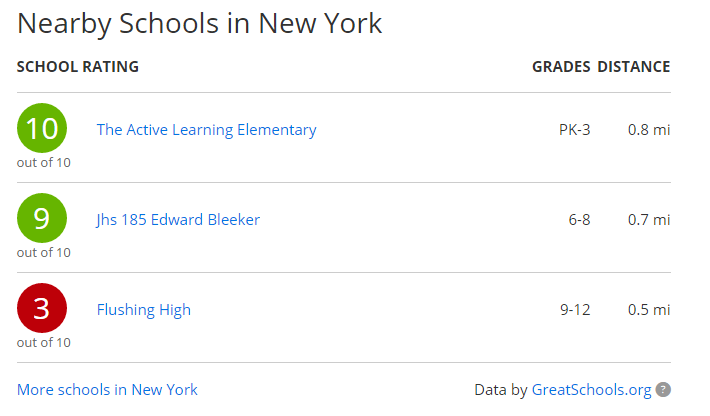

In [56]:
#display an image from zillows page to confirm scraped school rating
from IPython.display import Image
Image(filename='scrapying.png') 

#Result

This is the result using current criteria. If this property is not of interest, I will need to relax other criteris (e.g. more zip codes) to find a more appropriate place to live.

Future work:
1. Cross check properties with nearby restaurant ratings using yelp data
2. Scrap transport rating of the property on each zillow page
3. Scrap greatschool.org to circumvent zillow's 1000 request per day limit for school data

This later work include import of Yelp data from:
https://www.yelp.com/dataset_challenge/dataset

In [ ]:
import pandas as pd

# read the entire file into a python array
with open('yelp_academic_dataset_business.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each cell of dataframe is a JSON object
# with more JSON objects within each cell
# all the nested JSON objects are stored as one
# object in each cell
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
yelp = pd.read_json(data_json_str)